# 2D Fourier transform

This notebook shows examples of 2D Fourier Transforms and their applications

In [25]:
%matplotlib inline

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import math

## The Fourier transform everyone should know - A hole / dot

In optics, we can treat every lens like it performs a fourier transform.
A small hole or a point like light source is therefore the easiest example.
It corresponds to the delta function / sine wave example in 1D.

First let's generate a 2D plane $N*N$, ideally of size $N=2^n$.

In [27]:
N = 256
x_size = 10
y_size = x_size # make it square
x = np.linspace(-x_size/2,x_size/2,N) # and symmetric around 0,0
y = np.linspace(-y_size/2,y_size/2,N)

Now let's make a hole

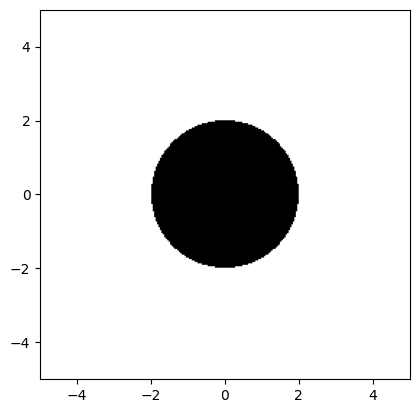

In [28]:
R = 2 # define a radius
xx, yy = np.meshgrid(x, y, sparse=True) # generate a meshgrid from our x,y coordinates
z = (np.sqrt(xx**2 + yy**2) >= R)*1  # set everything outside R and make it a number
plt.imshow(z, "gray", extent=[-x_size/2,x_size/2, -y_size/2,y_size/2])

Now let's take the Fourier transform

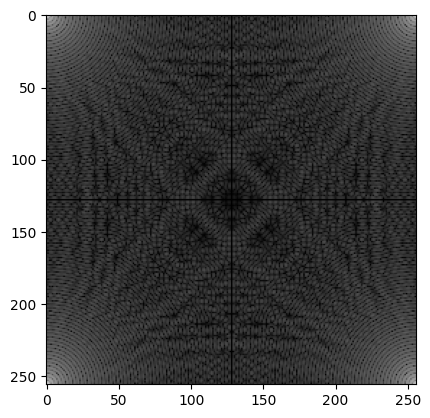

In [5]:
Fz = np.fft.fft2(z)
Fzcenter = np.fft.fftshift(Fz)
plt.imshow(np.log(1+np.abs(Fz)), "gray")

This is not quite what we want. The frequency starts at 0,0 and not in the middle of the plane.
Numpy has a convenient `fftshift()` function that centers the FFT in the plot:

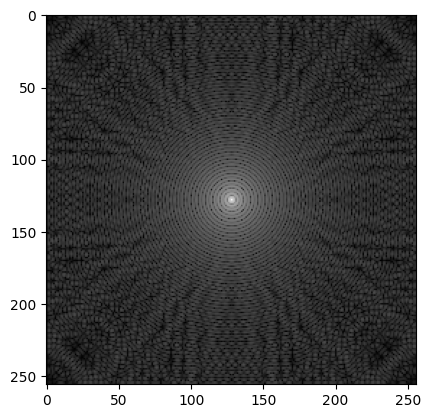

In [6]:
Fzcenter = np.fft.fftshift(Fz)
plt.imshow(np.log(1+np.abs(Fzcenter)), "gray")

Let's do some filtering.
We can reuse our "hole" to use as a mask in Fouries Space.

Let's take The inverse Fourier Transform of our filtered image:

In [7]:
from PIL import Image, ImageOps

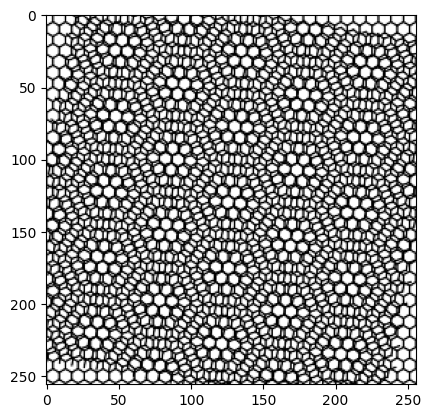

In [8]:
bilayer = np.array(ImageOps.grayscale(Image.open('lattice.png')))
plt.imshow(bilayer, "gray")

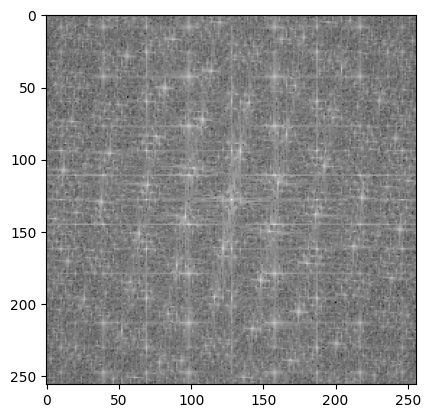

In [9]:
Fbilayer = np.fft.fft2(bilayer)
Fbilayercenter = np.fft.fftshift(Fbilayer)
plt.imshow(np.log(1+np.abs(Fbilayercenter)), "gray")

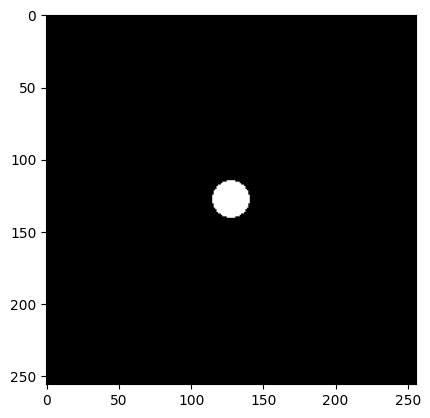

In [10]:
R = 0.5
xx, yy = np.meshgrid(x, y, sparse=True)
lowpass = (np.sqrt(xx**2 + yy**2) <= R)
plt.imshow(lowpass, "gray")

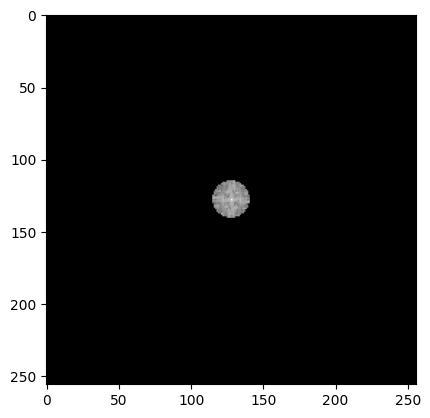

In [11]:
plt.imshow(np.log(1+np.abs(lowpass*Fbilayercenter)), "gray")

In [12]:
filtered = np.fft.ifft2(lowpass*Fbilayercenter)

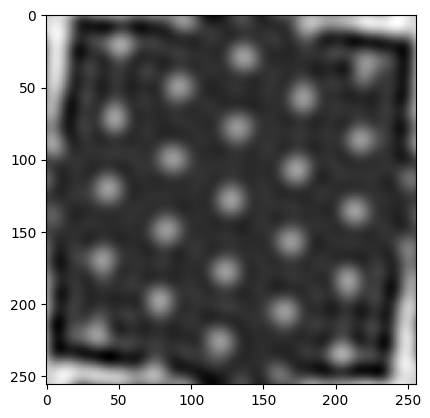

In [13]:
plt.imshow(np.log(1+np.abs(filtered)), "gray")

# Gaussian filter
Second example: create a Gaussian filter to smooth an image. We provide a photo (fire.jpg), as well as a photo with some graininess added (fire_grain2.jpg), and show the effect of the Gaussian filter. 

In [20]:
from scipy.ndimage import gaussian_filter

def my_gaussian_filter(image, sigma=1, plots=False):
    if np.size(image, axis=0) != np.size(image, axis=1):
        raise ValueError("I only work on square images")

    N = np.size(image, axis=0)
    fft = np.fft.fft2(image)
    gfilter = np.ones_like(fft)

    def gfilter_func(x):
        if sigma <= 0.:
            return x
        # The Fourier transform of a gaussian is a gaussian with width tau = N/(pi*sigma) (in units of k)
        tau = N / (np.pi * sigma)
        return np.exp(-1. * x**2 / tau**2) * 1. / (2 * np.pi * tau**2)**0.5
    
    # Map second half of frequencies to negative values
    def indexmap(i):
        return np.where(i > N/2, N-i, i)

    # Make array of "r" values for each point in the FFT (distance from 0, but mapping values beyond the Nyquist frequency to negative frequencies)
    ix, iy = np.indices(fft.shape)
    r = (indexmap(ix)**2 + indexmap(iy)**2)**0.5

    # Multiply FFT by Gaussian, preserving the normalization
    fft_filtered = fft * gfilter_func(r)
    fft_filtered = fft_filtered * (np.sum(np.abs(fft)**2) / np.sum(np.abs(fft_filtered)**2))
    #print(gfilter_func(r))

    # Inverse FFT
    image_filtered = np.abs(np.fft.ifft2(fft_filtered), gfilter_func(r))

    # Plots on demand
    if plots:
        fig, axs = plt.subplots(2, 2, figsize=(8, 8))
        axs[0, 0].imshow(image, "gray", label="Original")
        axs[0, 0].set_title("Original")
        axs[0, 1].imshow(image_filtered, "gray")
        axs[0, 1].set_title("Filtered")
        axs[1, 0].imshow(np.log(1. + np.abs(np.fft.fftshift(fft))))
        axs[1, 0].set_title("FFT")
        axs[1, 1].imshow(np.log(1. + np.abs(np.fft.fftshift(fft_filtered))))
        axs[1, 1].set_title("Filtered FFT")
        fig.suptitle(rf"Gaussian filter, $\sigma={sigma}$")
        return image_filtered, fig, axs
    else:
        return image_filtered




Text(0.5, 1.0, 'Fourier')

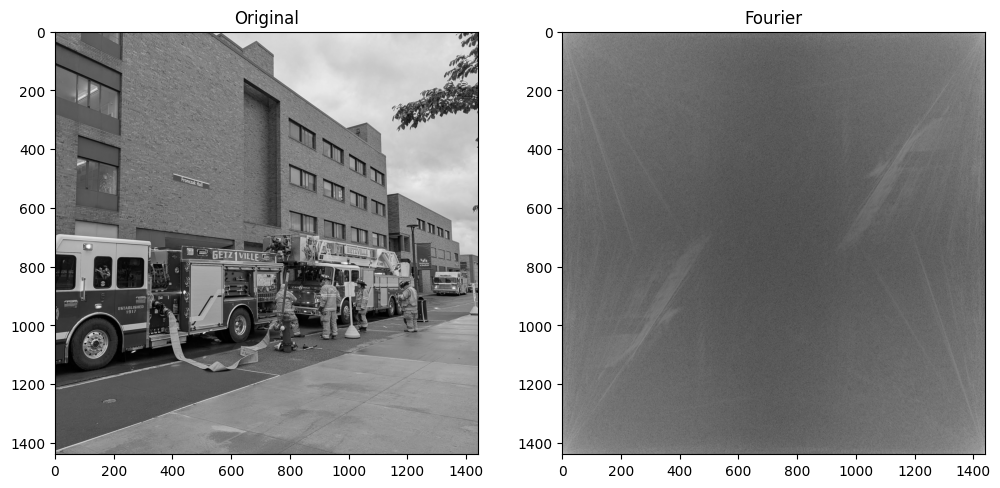

In [21]:
fire = np.array(ImageOps.grayscale(Image.open('fire.jpg')))
fire_fft = np.fft.fft2(fire)
fire_fft_centered = np.fft.fftshift(fire_fft)
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].imshow(fire, "gray")
axs[0].set_title("Original")
axs[1].imshow(np.log(1+np.abs(fire_fft)), "gray")
axs[1].set_title("Fourier")

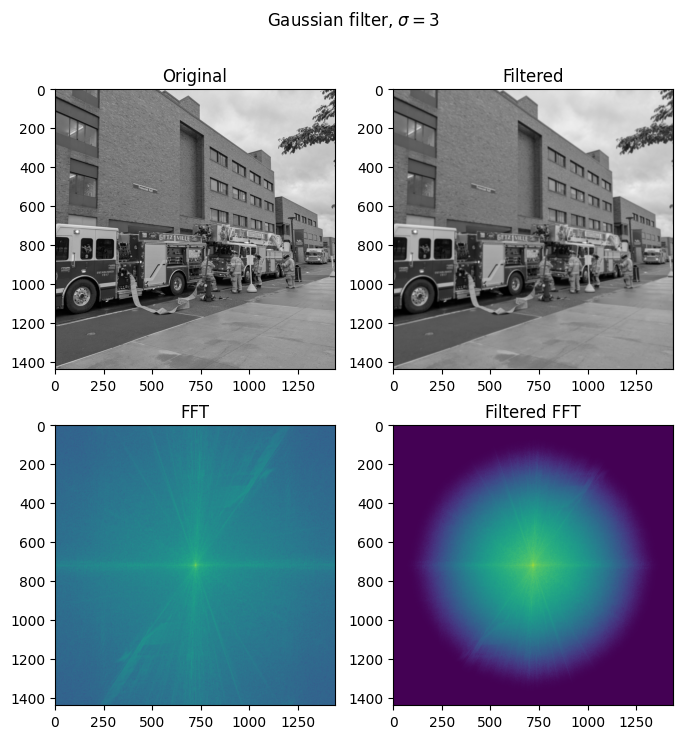

In [22]:
# Demonstrate what the filter is doing
filtered_image, fig, axs = my_gaussian_filter(fire, sigma=3, plots=True)

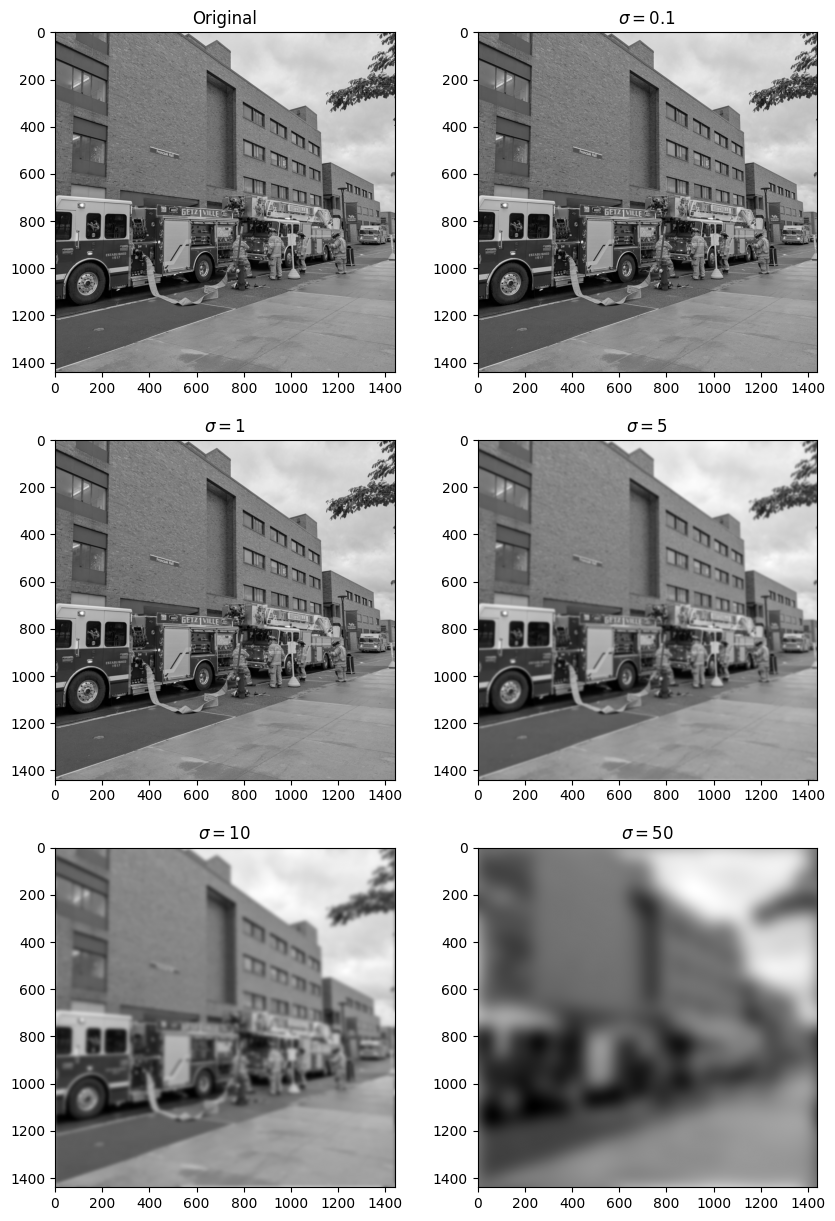

In [23]:
# Compare sigma values
filtered_images = []
sigmas = [0.1, 1, 5, 10, 50]

# Dynamically create subplots in 2 columns
plt_width = 2 # 2 horizontal subfigs
nfigs = len(sigmas)+1 # Also plot original
f, axs = plt.subplots(math.ceil(nfigs / plt_width), plt_width, figsize=(5 * plt_width, 5 * math.ceil(nfigs/plt_width)))

axs[0, 0].imshow(fire, "grey")
axs[0, 0].set_title("Original")
for i, sigma in enumerate(sigmas):
    filtered_images.append(my_gaussian_filter(fire, sigma=sigma))
    ifig_x = (i+1) // plt_width
    ifig_y = (i+1) % plt_width
    axs[ifig_x, ifig_y].imshow(filtered_images[-1], "gray")
    axs[ifig_x, ifig_y].set_title(rf"$\sigma={sigma}$")
    

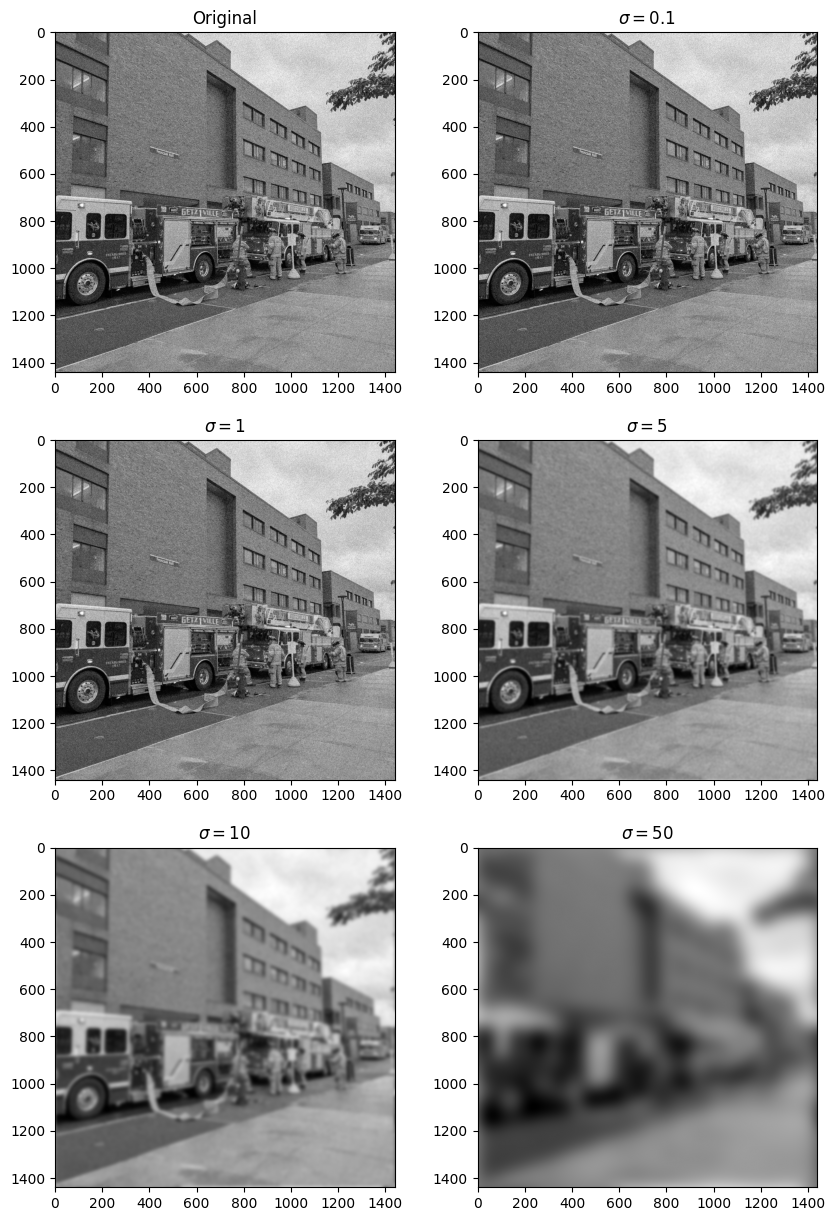

In [18]:
# Same thing but for a  grainier image
fire_grain = np.array(ImageOps.grayscale(Image.open('fire_grain.jpg')))

# Compare sigma values
filtered_images = []
sigmas = [0.1, 1, 5, 10, 50]

# Dynamically create subplots in 2 columns
plt_width = 2 # 2 horizontal subfigs
nfigs = len(sigmas)+1 # Also plot original
f, axs = plt.subplots(math.ceil(nfigs / plt_width), plt_width, figsize=(5 * plt_width, 5 * math.ceil(nfigs/plt_width)))

axs[0, 0].imshow(fire_grain, "grey")
axs[0, 0].set_title("Original")
for i, sigma in enumerate(sigmas):
    filtered_images.append(my_gaussian_filter(fire_grain, sigma=sigma))
    ifig_x = (i+1) // plt_width
    ifig_y = (i+1) % plt_width
    axs[ifig_x, ifig_y].imshow(filtered_images[-1], "gray")
    axs[ifig_x, ifig_y].set_title(rf"$\sigma={sigma}$")
    

Text(0.5, 1.0, 'Low pass filter, R=50')

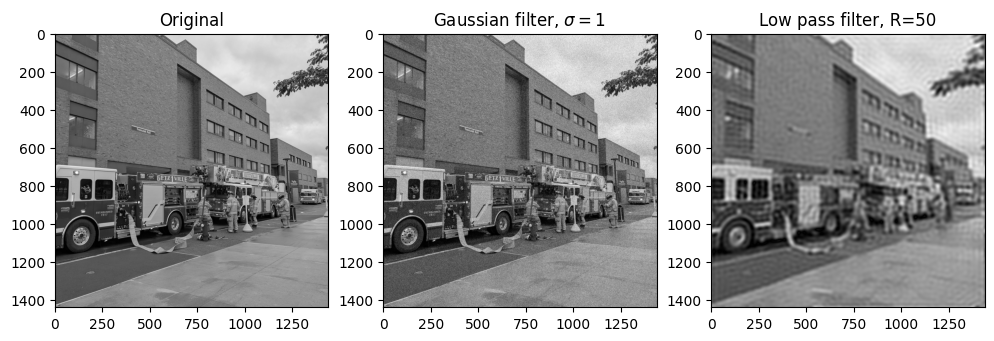

In [24]:
# Compare Gaussian filter with low pass filter
fire_grain = np.array(ImageOps.grayscale(Image.open('fire_grain.jpg')))
sigma = 1
fire_gauss = my_gaussian_filter(fire_grain, sigma=sigma)

# Low pass filter
def my_lowpass_filter(image, R=1, plots=False):
    if np.size(image, axis=0) != np.size(image, axis=1):
        raise ValueError("I only work on square images")

    N = np.size(image, axis=0)
    fft = np.fft.fft2(image)
    gfilter = np.ones_like(fft)

    def lowpass_func(x):
        return np.where(x < R, 1, 0)
    
    # Map second half of frequencies to negative values
    def indexmap(i):
        return np.where(i > N/2, N-i, i)

    # Make array of "r" values for each point in the FFT (distance from 0, but mapping values beyond the Nyquist frequency to negative frequencies)
    ix, iy = np.indices(fft.shape)
    r = (indexmap(ix)**2 + indexmap(iy)**2)**0.5

    # Multiply FFT by lowpass, preserving the normalization
    fft_filtered = fft * lowpass_func(r)
    fft_filtered = fft_filtered * (np.sum(np.abs(fft)**2) / np.sum(np.abs(fft_filtered)**2))

    # Inverse FFT
    image_filtered = np.abs(np.fft.ifft2(fft_filtered))

    return image_filtered

R = 50
fire_lowpass = my_lowpass_filter(fire_grain, R)

fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(fire, "gray")
axs[0].set_title("Original")
axs[1].imshow(fire_gauss, "gray")
axs[1].set_title(rf"Gaussian filter, $\sigma={sigma}$")
axs[2].imshow(fire_lowpass, "gray")
axs[2].set_title(rf"Low pass filter, R={R}")

